# Imports

TO RUN:
- Make sure to select Runtime>Change Runtime Type>T4 GPU to use cuda
- Load in data .json
- Install pytorch_lightning

In [1]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 63.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.distributions import Normal

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
from torch.utils.data import DataLoader
from pytorch_lightning import LightningDataModule
import seaborn as sns

import json
import random
from tqdm.notebook import tqdm_notebook
from time import time
import datetime
import pickle
import matplotlib.lines as mlines

# Functions and Classes

In [3]:
def seabornSettings():
    sns.set_theme('notebook', style='whitegrid', palette='Paired', rc={"lines.linewidth": 2.5, "font.size": 10, "axes.titlesize": 12, "axes.labelsize": 12,'xtick.labelsize': 9.0, 'ytick.labelsize': 9.0, "font.family": "serif"})
    return

In [4]:
from sklearn.decomposition import PCA

def plot_latent_space_with_clusters(samples, labels, num_clusters, cluster_means, cluster_logvars, savepath,
                                    text_labels, label_colors, data_colors, epoch_num=None, x_min=None, x_max=None, y_min=None, y_max=None, dpi=100):


    # savepath = dirname + postfix + 'latent_epoch' + str(epoch)
    latent_dim = samples.shape[1]
    # print(latent_dim)
    # print(samples.shape)
    # print(cluster_means.shape)
    # print(cluster_logvars.shape)

    if latent_dim == 2:
        samples_ = samples
        cluster_means_ = cluster_means
        cluster_stds_ = torch.exp(0.5 * cluster_logvars)
        cluster_angles_ = torch.zeros(num_clusters)

    elif latent_dim > 2:
        pca = PCA(n_components=2)
        samples_ = pca.fit_transform(samples)
        cluster_means_ = pca.transform(cluster_means)
        A = pca.components_  # projection matrix
        C = torch.diag_embed(torch.exp(cluster_logvars)) # covariance matrix [num_clusters, latent_dim, latent_dim]
        C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
        u, s, vh = np.linalg.svd(C_proj, full_matrices=True)
        cluster_stds_ = np.sqrt(s)
        cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])

    fig, ax = plt.subplots(figsize=(6.5,4))
    markers = ['o', '^', "s", "d"]
    assert(len(markers) >= len(text_labels))

    for i in range(len(text_labels)):
        samples_i = samples_[labels == i]
        if samples_i.shape[0] > 0:
          ax.scatter(samples_i[:, 0], samples_i[:, 1], marker=markers[i], s=50, label=text_labels[i], color=data_colors[i])

    for i in range(num_clusters):
        ax.plot(cluster_means_[i, 0], cluster_means_[i, 1], 'x', markersize=12, label=text_labels[i]+r' $\mu$', color=label_colors[i])
        ellipse2 = mpatches.Ellipse(xy=cluster_means_[i], width=4.0 * cluster_stds_[i, 0],
                                    height=4.0 * cluster_stds_[i, 1],  angle=cluster_angles_[i] * 180 / np.pi,
                                    label=text_labels[i]+r' $2\sigma$', color=label_colors[i], alpha=0.5)
        ax.add_patch(ellipse2)

    if latent_dim == 2:
        ax.set_xlabel('$z_1$')
        ax.set_ylabel('$z_2$')
    elif latent_dim > 2:
        ax.set_xlabel('PC$(z)_1$')
        ax.set_ylabel('PC$(z)_2$')

    if x_min is not None:
        ax.set_xlim([x_min, x_max])
    if y_min is not None:
        ax.set_ylim([y_min, y_max])
    # ax.set_xlim([-90, 80])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax.legend(loc='best')
    if epoch_num is not None:
        plt.title("Latent Space Epoch {epoch_num}".format(epoch_num=epoch_num))
    else:
        plt.title("Latent Space")
    fig.tight_layout()
    fig.savefig(savepath + '.png', dpi=dpi)
    plt.close()


In [5]:
# Define encoder architecture
class Encoder(nn.Module):
    """ Neural network defining q(z | x). """

    def __init__(self, data_dim, latent_dim, hidden_dims=[32, 16, 8]):
        super().__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Sequential(
            nn.Linear(in_features=data_dim, out_features=hidden_dims[0]),
            nn.Tanh(),
            nn.Linear(in_features=hidden_dims[0], out_features=hidden_dims[1]),
            nn.Tanh(),
            nn.Linear(in_features=hidden_dims[1], out_features=hidden_dims[2]),
            nn.Tanh(),
            nn.Linear(in_features=hidden_dims[2], out_features=2 * latent_dim),
        )

    def forward(self, x):
        """ Returns Normal conditional distribution for q(z | x), with mean and
        log-variance output by a neural network.

        Args:
            x: (N, data_dim) torch.tensor
        Returns:
            Normal distribution with a batch of (N, latent_dim) means and standard deviations
        """
        # print("x device:", x.get_device())
        # print("param device:", list(self.parameters())[0].get_device())

        out = self.fc(x)
        mu = out[:, 0:latent_dim]
        logsigmasq = out[:, latent_dim:]

        return mu, logsigmasq

In [6]:
# Define decoder architecture
class Decoder(nn.Module):
    """ Neural network defining p(x | z) """

    def __init__(self, data_dim, latent_dim, hidden_dims=[8, 16, 32]):
        super().__init__()
        self.data_dim = data_dim

        self.fc = nn.Sequential(
            nn.Linear(in_features=latent_dim, out_features=hidden_dims[0]),
            nn.Tanh(),
            nn.Linear(in_features=hidden_dims[0], out_features=hidden_dims[1]),
            nn.Tanh(),
            nn.Linear(in_features=hidden_dims[1], out_features=hidden_dims[2]),
            nn.Tanh(),
            nn.Linear(in_features=hidden_dims[2], out_features=data_dim),
            # nn.ReLU() 11/18 commented out because I realized this was the issue with the velocity dropping to zero
        )

    def forward(self, z):
        """ Returns Bernoulli conditional distribution of p(x | z), parametrized
        by logits.
        Args:
            z: (N, latent_dim) torch.tensor
        Returns:
            Normal distribution with a batch of (N, data_dim)
        """
        out = self.fc(z)
        mu = out
        logsigmasq = torch.ones_like(mu) * np.log(decoder_var)

        return mu, logsigmasq

In [7]:
def encoder_step(x_list, encoder_list, decoder_list):
    """
    Maps D-modality data to distributions of latent embeddings.
    :param x_list: length-D list of (N, data_dim) torch.tensor
    :param encoder_list: length-D list of Encoder
    :param decoder_list: length-D list of Decoder
    :param params: dictionary of non-DNN parameters
    :return:
        mu: (N, latent_dim) torch.tensor containing the mean of embeddings
        sigma: (N, latent_dim) torch.tensor containing the std dev of embeddings
    """

    assert(len(encoder_list) == len(decoder_list))
    # assert (len(encoder_list) == len(x_list))

    if len(encoder_list) == 1:
        mu, logsigmasq = encoder_list[0].forward(x_list[0])

    else:
        # compute distribution of qz as product of experts
        qz_inv_var = 0
        qz_mean_inv_var = 0

        for d, encoder in enumerate(encoder_list):
            mu_, logsigmasq_ = encoder.forward(x_list[d])
            qz_inv_var += torch.exp(-logsigmasq_)
            qz_mean_inv_var += mu_ * torch.exp(-logsigmasq_)

        mu = qz_mean_inv_var / qz_inv_var  # mu = qz_mean
        logsigmasq = - torch.log(qz_inv_var)  # sigma = qz_stddev

    return mu, logsigmasq

def em_step(z, mu, logsigmasq, params, update_by_batch=False):
    # compute gamma_c ~ p(c|z) for each x
    pi_c = params['pi_c']
    mu_c = params['mu_c']  # (K, Z)
    logsigmasq_c = params['logsigmasq_c']  # (K, Z)
    sigma_c = torch.exp(0.5 * logsigmasq_c)

    log_prob_zc = Normal(mu_c, sigma_c).log_prob(z.unsqueeze(dim=1)).sum(dim=2) + torch.log(pi_c)  #[N, K]
    log_prob_zc -= log_prob_zc.logsumexp(dim=1, keepdims=True)
    gamma_c = torch.exp(log_prob_zc) + em_reg
    gamma_c /= gamma_c.sum(dim=1, keepdims=True)

    denominator = torch.sum(gamma_c, dim=0).unsqueeze(1)
    mu_c = torch.einsum('nc,nz->cz', gamma_c, mu) / denominator
    logsigmasq_c = torch.log(torch.einsum('nc,ncz->cz', gamma_c, torch.square(mu.unsqueeze(dim=1) - mu_c) + torch.exp(logsigmasq).unsqueeze(dim=1))) - torch.log(denominator)

    if not update_by_batch:
        return gamma_c, mu_c, logsigmasq_c

    else:
        hist_weights = params['hist_weights']
        hist_mu_c = params['hist_mu_c']
        hist_logsigmasq_c = params['hist_logsigmasq_c']

        curr_weights = denominator
        new_weights = hist_weights + curr_weights
        new_mu_c = (hist_weights * hist_mu_c + curr_weights * mu_c) / new_weights
        new_logsigmasq_c = torch.log(hist_weights * torch.exp(hist_logsigmasq_c) +
                                      curr_weights * torch.exp(logsigmasq_c)) - torch.log(new_weights)

        params['hist_weights'] = new_weights
        params['hist_mu_c'] = new_mu_c
        params['hist_logsigmasq_c'] = new_logsigmasq_c
        return gamma_c, new_mu_c, new_logsigmasq_c



def decoder_step(x_list, z, encoder_list, decoder_list, params, mu, logsigmasq, gamma_c):
    """
    Computes a stochastic estimate of the ELBO.
    :param x_list: length-D list of (N, data_dim) torch.tensor
    :param z: MC samples of the encoded distributions
    :param encoder_list: length-D list of Encoder
    :param decoder_list: length-D list of Decoder
    :param params: dictionary of non-DNN parameters
    :return:
        elbo: (,) tensor containing the elbo estimation
    """
    assert(len(encoder_list) == len(decoder_list))

    # sigma = torch.exp(0.5 * logsigmasq)
    mu_c = params['mu_c']
    logsigmasq_c = params['logsigmasq_c']
    pi_c = params['pi_c']

    sse = 0
    elbo = 0
    elbo_terms = np.zeros(4)
    for d, decoder in enumerate(decoder_list):
        mu_, logsigmasq_ = decoder.forward(z)
        elbo += Normal(mu_, torch.exp(0.5 * logsigmasq_)).log_prob(x_list[d]).sum()
        elbo_terms[0] = Normal(mu_, torch.exp(0.5 * logsigmasq_)).log_prob(x_list[d]).sum()
        sse += torch.sum((x_list[d] - mu_) ** 2)
    # elbo += - 0.5 * sse
    elbo += - 0.5 * torch.sum(gamma_c * (logsigmasq_c + (torch.exp(logsigmasq).unsqueeze(1) + (mu.unsqueeze(1) - mu_c) ** 2) / torch.exp(logsigmasq_c)).sum(dim=2))
    elbo_terms[1] = - 0.5 * torch.sum(gamma_c * (logsigmasq_c + (torch.exp(logsigmasq).unsqueeze(1) + (mu.unsqueeze(1) - mu_c) ** 2) / torch.exp(logsigmasq_c)).sum(dim=2))
    elbo += torch.sum(gamma_c * (torch.log(pi_c) - torch.log(gamma_c))) + 0.5 * torch.sum(1 + logsigmasq)
    elbo_terms[2] = torch.sum(gamma_c * (torch.log(pi_c) - torch.log(gamma_c)))
    elbo_terms[3] = 0.5 * torch.sum(1 + logsigmasq)
    # print(elbo)
    # print(elbo_terms.sum())
    # print(elbo_terms)

    return elbo, sse, elbo_terms

# Data Loader

In [8]:
class AerocaptureDataModuleCUDA(LightningDataModule):
    def __init__(self, data_dir: str = "./", n_train: int = 5000, n_val: int = 100, n_test: int = 100,
                 train_batch: int = 1, val_batch: int = 1, test_batch: int = 1, num_workers=8):
        super().__init__()
        self.data_dir = data_dir
        self.n_train = n_train
        self.n_val = n_val
        self.n_test = n_test
        self.n_samples = n_train + n_val + n_test
        self.train_batch = train_batch
        self.val_batch = val_batch
        self.test_batch = test_batch
        self.num_workers = num_workers
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(self.device)
        self.downsampleNum = downsampleNum

    def setup(self, stage=None):

        f = open(self.data_dir)
        print('Loading File...')
        data_dict = json.load(f)
        # data_dict = pickle.load(f)
        print('...File Loaded')

        assert (self.n_samples <= len(data_dict))

        data_tr = []
        label_tr = []
        data_val = []
        label_val = []
        data_test = []
        label_test = []

        # Randomize samples
        total_samples = len(data_dict)
        sample_list = random.sample(range(total_samples), self.n_samples)

        # ASSUMES DATA IS ALREADY DOWNSAMPLED AND SCALED
        for i in tqdm_notebook(range(self.n_samples)):
            j = sample_list[i]
            this_data = np.array(data_dict[f'sample{j}']['energy'])[:]
            this_label = data_dict[f'sample{j}']['label']

            if i >= 0 and i < self.n_train:
                data_tr.append(torch.tensor(this_data, dtype=torch.float).to(self.device))
                label_tr.append(torch.tensor(this_label, dtype=torch.uint8).to(self.device))
            elif i >= self.n_train and i < self.n_train + self.n_val:
                data_val.append(torch.tensor(this_data, dtype=torch.float).to(self.device))
                label_val.append(torch.tensor(this_label, dtype=torch.uint8).to(self.device))
            else:
                data_test.append(torch.tensor(this_data, dtype=torch.float).to(self.device))
                label_test.append(torch.tensor(this_label, dtype=torch.uint8).to(self.device))

        self.train_dataset = tuple(zip(data_tr, label_tr))
        self.val_dataset = tuple(zip(data_val, label_val))
        self.test_dataset = tuple(zip(data_test, label_test))

        self.input_dim = len(self.train_dataset[0][0])

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            self.train_stage_dataset = self.train_dataset
            self.val_stage_dataset = self.val_dataset

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.test_stage_dataset = self.test_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.train_batch, shuffle=False, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.val_batch, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.test_batch, shuffle=False, num_workers=self.num_workers)

# Check Devices

In [9]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set default tensor type to CUDA tensors
torch.set_default_tensor_type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor)
#torch.set_default_tensor_type(torch.FloatTensor)
print(device)

cuda


/usr/local/lib/python3.11/dist-packages/torch/__init__.py:1236: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [10]:
print(device)

cuda


# Settings

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
r = 0
n_train = 1024
n_val = 128
n_test = 128
# For testing small batches of data
# n_train = 400
# n_val = 50
# n_test = 50
hd1 = 64
hd2 = 32
hd3 = 16
latent_dim = 5
n_clusters = 4
lr = 1e-3
n_epochs = 30_000 # 30_000
batch_size = 64
em_reg = 1e-6
decoder_var = 1e-5

plot_interval = 1000
dpi = 300

K = n_clusters
Z = latent_dim
D = 1  #num_modalities

downsampleNum = 64

# Numpy random seed
np.random.seed(r)

# PyTorch random seed for CPU
torch.manual_seed(r)

# PyTorch random seed for all GPU operations (if using CUDA)
torch.cuda.manual_seed(r)
torch.cuda.manual_seed_all(r)

# Ensure deterministic behavior for PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set Up Data Loader

In [26]:
from datetime import datetime
timestr = datetime.strftime(datetime.now(), "%Y%m%d_%H%M%S")

In [27]:
# Load in old data
# dirname = os.path.join("drive", "MyDrive", "GMVAE_guided_aerocapture", 'gmvae_em_aerocapture_energy_20250213_215721')
# generate new data path
dirname = os.path.join("drive", "MyDrive", "JP_gmvae_data", "gmvae_em_aerocapture_energy_"+timestr)
os.makedirs(dirname, exist_ok=True)
print("Filepath directory: " + dirname)

postfix = '_{0:d}_{1:d}_{2:d}_{3:d}_{4:d}_{5:d}_{6:d}_{7:d}_{8:d}_{9:f}_{10:d}_{11:f}_{12:f}_{13:d}_'.format(
          r, n_train, n_val, n_test, hd1, hd2, hd3, latent_dim, n_clusters, lr, batch_size, em_reg * 1e3, decoder_var, n_epochs)
print("Filepath postfix: " + postfix)

Filepath directory: drive/MyDrive/JP_gmvae_data/gmvae_em_aerocapture_energy_20250320_204111
Filepath postfix: _0_1024_128_128_64_32_16_4_4_0.001000_64_0.001000_0.000010_30000_


cuda
Loading File...
...File Loaded


  0%|          | 0/1280 [00:00<?, ?it/s]

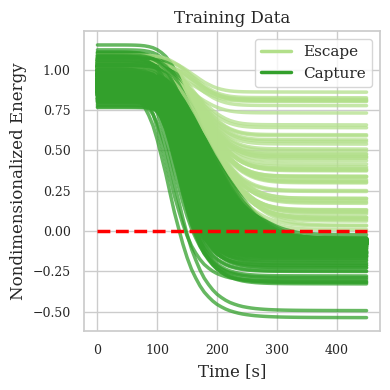

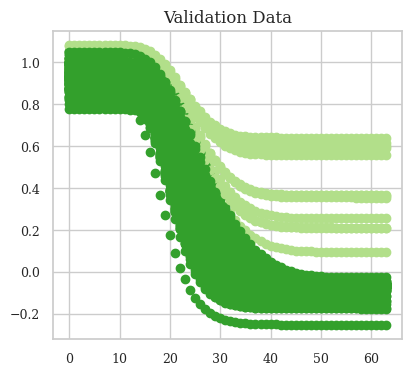

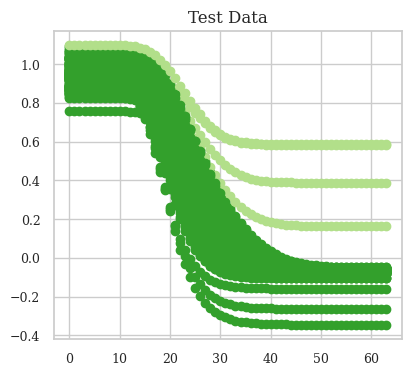

In [28]:
# data = 'jens_vel_data_correct_clusters'
# data = 'jens_shorter_data'
data = 'UOP_training_data_5000_scaled_downsampled_energy'
data_dir = os.path.join("drive", "MyDrive", "JP_gmvae_data", f"{data}.json")
# data_dir = f'{data}.pkl'

data_module = AerocaptureDataModuleCUDA(data_dir=data_dir, n_train=n_train, n_val=n_val, n_test=n_test,
                                  train_batch=batch_size, val_batch=batch_size, test_batch=batch_size,
                                  num_workers=0)

data_module.setup("fit")

train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()
data_dim = len(train_loader.dataset[0][0])
text_labels = ['capture', 'escape']
label_colors = ['C2', 'C3']

num_train_batches = len(train_loader)

ts_plot = np.linspace(0,450,64)
seabornSettings()
fig, ax = plt.subplots(figsize=(4, 4))
for j in range(n_train):
    # print(len(train_loader.dataset[j][0].cpu()))
    ax.plot(ts_plot, train_loader.dataset[j][0].cpu(), color=label_colors[train_loader.dataset[j][1].cpu()], alpha=0.75)

eline = mlines.Line2D([], [], color='C2', label='Escape')
cline = mlines.Line2D([], [], color='C3', label='Capture')
plt.legend(handles=[eline, cline])
plt.hlines(0, 0, ts_plot[-1], colors='r', linestyles='dashed')
plt.xlabel("Time [s]")
plt.ylabel("Nondimensionalized Energy")
plt.title("Training Data")
plt.tight_layout()
fig.savefig(os.path.join(dirname, 'train_data'+postfix+'.png'), dpi=dpi)

fig, ax = plt.subplots(figsize=(4.5, 4))
for j in range(n_val):
    ax.scatter(np.arange(downsampleNum), val_loader.dataset[j][0].cpu(), color=label_colors[val_loader.dataset[j][1].cpu()])
plt.title("Validation Data")
fig.savefig(os.path.join(dirname, 'val_data'+postfix+'.png'), dpi=dpi)

fig, ax = plt.subplots(figsize=(4.5, 4))
for j in range(n_test):
    ax.scatter(np.arange(downsampleNum), test_loader.dataset[j][0].cpu(), color=label_colors[test_loader.dataset[j][1].cpu()])
plt.title("Test Data")
fig.savefig(os.path.join(dirname, 'test_data'+postfix+'.png'), dpi=dpi)

# Print number of capture / escape in each training set TODO


# Run GMVAE

In [29]:
# initialize latent GMM model parameters
params = {}
pi_variables = torch.zeros(K).clone().detach().requires_grad_(True)
params['pi_c'] = torch.ones(K) / K
params['mu_c'] = torch.rand((K, Z)) * 2.0 - 1.0
params['logsigmasq_c'] = torch.zeros((K, Z))


text_labels = [f'Cluster {i}' for i in range((n_clusters))]
label_colors = [f'C{i+1}' for i in range((n_clusters))]

# initialize neural networks
encoder_list = []
decoder_list = []
trainable_parameters = []
trainable_parameters.append(pi_variables)

for _ in range(D):
    encoder = Encoder(data_dim=data_dim, latent_dim=latent_dim, hidden_dims=[hd1, hd2, hd3])
    decoder = Decoder(data_dim=data_dim, latent_dim=latent_dim, hidden_dims=[hd3, hd2, hd1])
    encoder_list.append(encoder)
    decoder_list.append(decoder)
    trainable_parameters += list(encoder.parameters()) + list(decoder.parameters())

optimizer = optim.Adam(trainable_parameters, lr=lr)

# training

import time
ts = time.time()
tic = time.perf_counter()

train_loss = torch.zeros(n_epochs)
train_elbo_terms = torch.zeros((n_epochs, 4)) # 4 ELBO terms
val_elbo_terms = torch.zeros((n_epochs, 4)) # 4 ELBO terms
val_loss = torch.zeros(n_epochs)
pi_history = torch.zeros((n_epochs, K))
train_mse_history = torch.zeros(n_epochs)
val_mse_history = torch.zeros(n_epochs)
min_val_loss = torch.inf
seabornSettings()

for epoch in range(n_epochs):
    ti = time.time()
    for encoder in encoder_list:
        encoder.train()
    for decoder in decoder_list:
        decoder.train()

    train_elbo = 0
    train_mse = 0
    train_elbo_term = np.zeros(4)
    params['hist_weights'] = torch.zeros((K, 1))
    params['hist_mu_c'] = torch.zeros((K, latent_dim))
    params['hist_logsigmasq_c'] = torch.zeros((K, latent_dim))

    for (batch_idx, batch) in enumerate(train_loader):
        batch_x, _ = batch
        x_list = [batch_x]  # assume D=2 and each modality has data_dim
        optimizer.zero_grad()
        pi_c = torch.exp(pi_variables) / torch.sum(torch.exp(pi_variables))
        params['pi_c'] = pi_c

        mu, logsigmasq = encoder_step(x_list, encoder_list, decoder_list)
        sigma = torch.exp(0.5 * logsigmasq)
        eps = Normal(0, 1).sample(mu.shape)
        z = mu + eps * sigma

        with torch.no_grad():
            gamma_c, mu_c, logsigmasq_c = em_step(z, mu, logsigmasq, params, update_by_batch=True)
        params['mu_c'] = mu_c
        params['logsigmasq_c'] = logsigmasq_c

        elbo, sse, elbo_terms = decoder_step(x_list, z, encoder_list, decoder_list, params, mu, logsigmasq, gamma_c)
        train_elbo += elbo.item()
        train_elbo_term += elbo_terms
        train_mse += sse.item()
        loss = - elbo / batch_x.shape[0]
        loss.backward()
        optimizer.step()

    for encoder in encoder_list:
        encoder.eval()
    for decoder in decoder_list:
        decoder.eval()

    if epoch % plot_interval == 0 or epoch == n_epochs:
        # Plot the first two dimensions of the latents
        with torch.no_grad():
            means = []
            samples = []
            labels = []
            for batch in train_loader:
                batch_x, batch_label = batch
                x_list = [batch_x]
                mean, logsigmasq = encoder_step(x_list, encoder_list, decoder_list)
                sigma = torch.exp(0.5 * logsigmasq)
                eps = Normal(0, 1).sample(mean.shape)
                z = mean + eps * sigma
                means.append(mean)
                samples.append(z)
                labels.append(batch_label)

        means = torch.vstack(means).cpu()
        samples = torch.vstack(samples).cpu()
        labels = torch.hstack(labels).cpu()

        savepath = os.path.join(dirname, "latent_samples_epoch_" + str(epoch) + postfix)
        plot_latent_space_with_clusters(samples, labels, K, mu_c.cpu(), logsigmasq_c.cpu(), savepath, text_labels, label_colors, label_colors, epoch, dpi=dpi)

        savepath = os.path.join(dirname, "latent_means_epoch_" + str(epoch) + postfix)
        plot_latent_space_with_clusters(means, labels, K, mu_c.cpu(), logsigmasq_c.cpu(), savepath, text_labels, label_colors, label_colors, epoch, dpi=dpi)


        # plot samples from generative model
        n_gen = n_train
        cluster_probs = params['pi_c'].cpu().detach().numpy() #
        fig, ax = plt.subplots(figsize=(4.5, 4))
        for j in range(n_gen):
            c = np.random.choice(K, p=cluster_probs)
            mu_c = params['mu_c'][c].clone().detach()
            sigma_c = torch.exp(0.5 * params['logsigmasq_c'][c]).clone().detach()
            z = Normal(0, 1).sample(mu_c.shape) * sigma_c + mu_c
            mu_x = decoder.forward(z)[0]
            ax.plot(mu_x.cpu().detach().numpy())
        fig.savefig(os.path.join(dirname, "generate_samples_" + str(epoch) + postfix+ '.png'), dpi=dpi)
        plt.close()


    val_elbo = 0
    val_mse = 0
    val_elbo_term = np.zeros(4)
    with torch.no_grad():
        for (batch_idx, batch) in enumerate(val_loader):
            batch_x, _ = batch
            x_list = [batch_x]
            mu, logsigmasq = encoder_step(x_list, encoder_list, decoder_list)
            sigma = torch.exp(0.5 * logsigmasq)
            eps = Normal(0, 1).sample(mu.shape)
            z = mu + eps * sigma
            with torch.no_grad():
                gamma_c, _, _ = em_step(z, mu, logsigmasq, params)
            elbo, sse, elbo_items = decoder_step(x_list, z, encoder_list, decoder_list, params, mu, logsigmasq, gamma_c)
            val_elbo += elbo.item()
            val_mse += sse.item()
            val_elbo_term += elbo_items

    train_elbo /= len(train_loader.dataset)
    train_elbo_term = torch.tensor(train_elbo_term) / len(train_loader.dataset)
    val_elbo /= len(val_loader.dataset)
    val_elbo_term = torch.tensor(val_elbo_term) / len(val_loader.dataset)
    train_mse /= len(train_loader.dataset)
    val_mse /= len(val_loader.dataset)

    tf = time.time()
    toc = time.perf_counter()
    print('====> Epoch: {} Train ELBO: {:.4f} Val ELBO: {:.4f}, Epoch Time (s): {:.2f}, Total Time (hrs): {:.4f}'.format(epoch, train_elbo, val_elbo, tf-ti, (toc-tic)/60/60))

    train_loss[epoch] = - train_elbo
    val_loss[epoch] = - val_elbo
    train_elbo_terms[epoch,:] = - train_elbo_term
    val_elbo_terms[epoch,:] = - val_elbo_term
    pi_history[epoch] = params['pi_c']
    train_mse_history[epoch] = train_mse
    val_mse_history[epoch] = val_mse

    if - val_elbo < min_val_loss:
        min_val_loss = - val_elbo
        torch.save(params['pi_c'], os.path.join(dirname, 'gmm_params_pi'+ postfix + '.pt'))
        torch.save(params['mu_c'], os.path.join(dirname, 'gmm_params_mu'+ postfix + '.pt'))
        torch.save(params['logsigmasq_c'], os.path.join(dirname, 'gmm_params_logsigmasq'+ postfix + '.pt'))
        torch.save(encoder.state_dict(), os.path.join(dirname, 'encoder'+ postfix + '.pt'))
        torch.save(decoder.state_dict(), os.path.join(dirname, 'decoder'+ postfix + '.pt'))

    if epoch % plot_interval == 0 or epoch == n_epochs:
      # Plot the training and validation loss vs. epoch number
      plt.figure(figsize=(4.5, 4))
      # const = min(min(train_loss), min(val_loss))
      train_loss_adjusted = train_loss
      val_loss_adjusted = val_loss
      plt.plot(train_loss_adjusted.cpu()[:epoch], label='train')
      # print(train_loss_adjusted.cpu()[:epoch])
      plt.plot(val_loss_adjusted.cpu()[:epoch], label='val')
      plt.yscale('symlog')
      plt.xlabel("number of epochs")
      plt.ylabel("loss")
      plt.title("Negative Loss")
      plt.legend()
      plt.tight_layout()
      plt.savefig(os.path.join(dirname, 'elbo_'+ str(epoch)+postfix+'.png'), dpi=dpi)
      plt.close()

      # Plot each term of the training loss and validation loss
      plt.figure(figsize=(4.5, 4))
      labels = ["Reconstruction", "GMM Reg", "Prob Reg", "Encoder Var"]
      for ii in range(4):
        train_loss_adjusted = train_elbo_terms[:epoch, ii]
        val_loss_adjusted = val_elbo_terms[:epoch, ii]
        plt.plot(train_loss_adjusted.cpu()[:epoch], label=f"{labels[ii]}: Train")
        plt.plot(val_loss_adjusted.cpu()[:epoch], label=f"{labels[ii]}: Val", linestyle='--')
      plt.xlabel("number of epochs")
      plt.yscale('symlog')
      plt.ylabel("loss")
      plt.title("Negative Loss Terms")
      plt.legend()
      plt.tight_layout()
      plt.savefig(os.path.join(dirname, 'elbo_terms_'+ str(epoch)+postfix+'.png'), dpi=dpi)
      plt.close()

      # Plot the training and validation mse vs. epoch number
      plt.figure(figsize=(4.5, 4))
      plt.semilogy(train_mse_history.cpu().detach().numpy()[:epoch], label='train')
      plt.semilogy(val_mse_history.cpu().detach().numpy()[:epoch], label='val')
      plt.xlabel("number of epochs")
      plt.legend()
      plt.tight_layout()
      plt.savefig(os.path.join(dirname, 'reconst_mse_'+ str(epoch)+postfix+'.png'), dpi=dpi)
      plt.close()

      # Plot the history of pi
      plt.figure(figsize=(4.5, 4))
      for i in range(K):
          plt.plot(pi_history[:, i].cpu().detach().numpy()[:epoch], label=r'$\pi$' + str(i+1))
      plt.xlabel("number of epochs")
      plt.legend()
      plt.tight_layout()
      plt.savefig(os.path.join(dirname, 'pi_'+ str(epoch)+postfix+'.png'), dpi=dpi)
      plt.close()


te = time.time()
import datetime
duration = datetime.timedelta(seconds=te - ts)
print("Training took ", duration)

# Save off pi_history, train_loss, val_loss, train_mse_history, val_mse_history
torch.save(pi_history, os.path.join(dirname, 'pi_history'+ postfix + '.pt'))
torch.save(train_loss, os.path.join(dirname, 'train_loss'+ postfix + '.pt'))
torch.save(val_loss, os.path.join(dirname, 'val_loss'+ postfix + '.pt'))
torch.save(train_elbo_terms, os.path.join(dirname, 'train_elbo_terms'+ postfix + '.pt'))
torch.save(val_elbo_terms, os.path.join(dirname, 'val_elbo_terms'+ postfix + '.pt'))
torch.save(train_mse_history, os.path.join(dirname, 'train_mse_history'+ postfix + '.pt'))
torch.save(val_mse_history, os.path.join(dirname, 'val_mse_history'+ postfix + '.pt'))

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 0 Train ELBO: -788669.1680 Val ELBO: -541674.5625, Epoch Time (s): 3.76, Total Time (hrs): 0.0010
====> Epoch: 1 Train ELBO: -267846.7488 Val ELBO: -101409.6641, Epoch Time (s): 0.12, Total Time (hrs): 0.0014
====> Epoch: 2 Train ELBO: -66111.8911 Val ELBO: -68670.4570, Epoch Time (s): 0.14, Total Time (hrs): 0.0014
====> Epoch: 3 Train ELBO: -49216.9353 Val ELBO: -62483.2734, Epoch Time (s): 0.13, Total Time (hrs): 0.0015
====> Epoch: 4 Train ELBO: -45029.6901 Val ELBO: -61467.8594, Epoch Time (s): 0.13, Total Time (hrs): 0.0015
====> Epoch: 5 Train ELBO: -44101.4111 Val ELBO: -60859.2441, Epoch Time (s): 0.14, Total Time (hrs): 0.0016
====> Epoch: 6 Train ELBO: -43706.4988 Val ELBO: -60670.4238, Epoch Time (s): 0.13, Total Time (hrs): 0.0016
====> Epoch: 7 Train ELBO: -43413.8270 Val ELBO: -59949.0059, Epoch Time (s): 0.12, Total Time (hrs): 0.0016
====> Epoch: 8 Train ELBO: -43477.6904 Val ELBO: -59611.9941, Epoch Time (s): 0.13, Total Time (hrs): 0.0017
====> Epoch: 9 

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 1000 Train ELBO: 134.3883 Val ELBO: 75.1595, Epoch Time (s): 10.28, Total Time (hrs): 0.0438
====> Epoch: 1001 Train ELBO: 165.4006 Val ELBO: 150.2870, Epoch Time (s): 0.13, Total Time (hrs): 0.0443
====> Epoch: 1002 Train ELBO: 145.2817 Val ELBO: 37.6898, Epoch Time (s): 0.13, Total Time (hrs): 0.0443
====> Epoch: 1003 Train ELBO: 128.5139 Val ELBO: 81.0831, Epoch Time (s): 0.14, Total Time (hrs): 0.0444
====> Epoch: 1004 Train ELBO: 158.8077 Val ELBO: 157.4617, Epoch Time (s): 0.13, Total Time (hrs): 0.0444
====> Epoch: 1005 Train ELBO: 168.1275 Val ELBO: 98.9600, Epoch Time (s): 0.16, Total Time (hrs): 0.0444
====> Epoch: 1006 Train ELBO: 155.6398 Val ELBO: 91.2931, Epoch Time (s): 0.13, Total Time (hrs): 0.0445
====> Epoch: 1007 Train ELBO: 149.9629 Val ELBO: 122.8717, Epoch Time (s): 0.14, Total Time (hrs): 0.0445
====> Epoch: 1008 Train ELBO: 171.4807 Val ELBO: 147.7503, Epoch Time (s): 0.14, Total Time (hrs): 0.0446
====> Epoch: 1009 Train ELBO: 158.8037 Val ELBO: 1

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 2000 Train ELBO: 210.8849 Val ELBO: 117.4166, Epoch Time (s): 3.85, Total Time (hrs): 0.0836
====> Epoch: 2001 Train ELBO: 193.4215 Val ELBO: 143.5261, Epoch Time (s): 0.13, Total Time (hrs): 0.0841
====> Epoch: 2002 Train ELBO: 200.4724 Val ELBO: 169.4271, Epoch Time (s): 0.13, Total Time (hrs): 0.0842
====> Epoch: 2003 Train ELBO: 215.5130 Val ELBO: 177.6047, Epoch Time (s): 0.13, Total Time (hrs): 0.0842
====> Epoch: 2004 Train ELBO: 212.6770 Val ELBO: 173.5076, Epoch Time (s): 0.14, Total Time (hrs): 0.0842
====> Epoch: 2005 Train ELBO: 219.1979 Val ELBO: 177.4956, Epoch Time (s): 0.13, Total Time (hrs): 0.0843
====> Epoch: 2006 Train ELBO: 226.9596 Val ELBO: 193.0747, Epoch Time (s): 0.12, Total Time (hrs): 0.0843
====> Epoch: 2007 Train ELBO: 206.7494 Val ELBO: 143.9645, Epoch Time (s): 0.13, Total Time (hrs): 0.0844
====> Epoch: 2008 Train ELBO: 187.2916 Val ELBO: 131.4376, Epoch Time (s): 0.12, Total Time (hrs): 0.0844
====> Epoch: 2009 Train ELBO: 212.6549 Val ELB

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 3000 Train ELBO: 262.0370 Val ELBO: 237.8595, Epoch Time (s): 3.63, Total Time (hrs): 0.1229
====> Epoch: 3001 Train ELBO: 251.2364 Val ELBO: 208.0544, Epoch Time (s): 0.12, Total Time (hrs): 0.1236
====> Epoch: 3002 Train ELBO: 231.6699 Val ELBO: 235.9254, Epoch Time (s): 0.12, Total Time (hrs): 0.1236
====> Epoch: 3003 Train ELBO: 249.9553 Val ELBO: 238.8469, Epoch Time (s): 0.13, Total Time (hrs): 0.1237
====> Epoch: 3004 Train ELBO: 258.5593 Val ELBO: 225.4835, Epoch Time (s): 0.12, Total Time (hrs): 0.1237
====> Epoch: 3005 Train ELBO: 261.1673 Val ELBO: 234.8053, Epoch Time (s): 0.13, Total Time (hrs): 0.1237
====> Epoch: 3006 Train ELBO: 260.3268 Val ELBO: 241.0250, Epoch Time (s): 0.13, Total Time (hrs): 0.1238
====> Epoch: 3007 Train ELBO: 262.2457 Val ELBO: 246.4350, Epoch Time (s): 0.12, Total Time (hrs): 0.1238
====> Epoch: 3008 Train ELBO: 259.1688 Val ELBO: 242.8387, Epoch Time (s): 0.13, Total Time (hrs): 0.1238
====> Epoch: 3009 Train ELBO: 258.3494 Val ELB

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 4000 Train ELBO: 257.0011 Val ELBO: 149.5674, Epoch Time (s): 2.95, Total Time (hrs): 0.1616
====> Epoch: 4001 Train ELBO: 217.8998 Val ELBO: 216.9709, Epoch Time (s): 0.12, Total Time (hrs): 0.1622
====> Epoch: 4002 Train ELBO: 248.7395 Val ELBO: 255.8718, Epoch Time (s): 0.12, Total Time (hrs): 0.1623
====> Epoch: 4003 Train ELBO: 270.4632 Val ELBO: 242.2466, Epoch Time (s): 0.13, Total Time (hrs): 0.1623
====> Epoch: 4004 Train ELBO: 264.4383 Val ELBO: 201.3932, Epoch Time (s): 0.12, Total Time (hrs): 0.1623
====> Epoch: 4005 Train ELBO: 239.6181 Val ELBO: 232.2427, Epoch Time (s): 0.13, Total Time (hrs): 0.1624
====> Epoch: 4006 Train ELBO: 255.7706 Val ELBO: 256.3554, Epoch Time (s): 0.12, Total Time (hrs): 0.1624
====> Epoch: 4007 Train ELBO: 272.8118 Val ELBO: 250.4139, Epoch Time (s): 0.13, Total Time (hrs): 0.1624
====> Epoch: 4008 Train ELBO: 265.9896 Val ELBO: 222.3500, Epoch Time (s): 0.12, Total Time (hrs): 0.1625
====> Epoch: 4009 Train ELBO: 253.8392 Val ELB

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 5000 Train ELBO: 265.9408 Val ELBO: 246.9701, Epoch Time (s): 3.06, Total Time (hrs): 0.2009
====> Epoch: 5001 Train ELBO: 269.2655 Val ELBO: 233.0253, Epoch Time (s): 0.12, Total Time (hrs): 0.2014
====> Epoch: 5002 Train ELBO: 264.5158 Val ELBO: 217.9116, Epoch Time (s): 0.12, Total Time (hrs): 0.2015
====> Epoch: 5003 Train ELBO: 240.6342 Val ELBO: 214.3962, Epoch Time (s): 0.12, Total Time (hrs): 0.2015
====> Epoch: 5004 Train ELBO: 255.9303 Val ELBO: 258.7887, Epoch Time (s): 0.12, Total Time (hrs): 0.2015
====> Epoch: 5005 Train ELBO: 264.5790 Val ELBO: 248.4206, Epoch Time (s): 0.13, Total Time (hrs): 0.2016
====> Epoch: 5006 Train ELBO: 263.6136 Val ELBO: 205.3921, Epoch Time (s): 0.12, Total Time (hrs): 0.2016
====> Epoch: 5007 Train ELBO: 231.1589 Val ELBO: 159.8496, Epoch Time (s): 0.12, Total Time (hrs): 0.2016
====> Epoch: 5008 Train ELBO: 247.6813 Val ELBO: 255.5177, Epoch Time (s): 0.13, Total Time (hrs): 0.2017
====> Epoch: 5009 Train ELBO: 263.9776 Val ELB

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 6000 Train ELBO: 267.3009 Val ELBO: 263.1973, Epoch Time (s): 3.35, Total Time (hrs): 0.2395
====> Epoch: 6001 Train ELBO: 280.6121 Val ELBO: 259.2214, Epoch Time (s): 0.13, Total Time (hrs): 0.2404
====> Epoch: 6002 Train ELBO: 279.5776 Val ELBO: 245.2656, Epoch Time (s): 0.13, Total Time (hrs): 0.2404
====> Epoch: 6003 Train ELBO: 273.4733 Val ELBO: 260.2021, Epoch Time (s): 0.13, Total Time (hrs): 0.2405
====> Epoch: 6004 Train ELBO: 275.4201 Val ELBO: 264.8269, Epoch Time (s): 0.12, Total Time (hrs): 0.2405
====> Epoch: 6005 Train ELBO: 276.9210 Val ELBO: 261.5047, Epoch Time (s): 0.12, Total Time (hrs): 0.2405
====> Epoch: 6006 Train ELBO: 273.3008 Val ELBO: 241.7440, Epoch Time (s): 0.12, Total Time (hrs): 0.2406
====> Epoch: 6007 Train ELBO: 267.3290 Val ELBO: 256.4943, Epoch Time (s): 0.13, Total Time (hrs): 0.2406
====> Epoch: 6008 Train ELBO: 274.6656 Val ELBO: 260.3481, Epoch Time (s): 0.13, Total Time (hrs): 0.2406
====> Epoch: 6009 Train ELBO: 273.4807 Val ELB

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 7000 Train ELBO: 264.0407 Val ELBO: 224.1053, Epoch Time (s): 2.96, Total Time (hrs): 0.2785
====> Epoch: 7001 Train ELBO: 268.5643 Val ELBO: 262.3593, Epoch Time (s): 0.12, Total Time (hrs): 0.2790
====> Epoch: 7002 Train ELBO: 268.8619 Val ELBO: 225.3392, Epoch Time (s): 0.13, Total Time (hrs): 0.2791
====> Epoch: 7003 Train ELBO: 273.9288 Val ELBO: 243.0338, Epoch Time (s): 0.18, Total Time (hrs): 0.2791
====> Epoch: 7004 Train ELBO: 224.5648 Val ELBO: -61.7240, Epoch Time (s): 0.18, Total Time (hrs): 0.2792
====> Epoch: 7005 Train ELBO: 198.4694 Val ELBO: 235.1120, Epoch Time (s): 0.17, Total Time (hrs): 0.2792
====> Epoch: 7006 Train ELBO: 251.6870 Val ELBO: 251.6722, Epoch Time (s): 0.16, Total Time (hrs): 0.2793
====> Epoch: 7007 Train ELBO: 258.7600 Val ELBO: 240.3832, Epoch Time (s): 0.16, Total Time (hrs): 0.2793
====> Epoch: 7008 Train ELBO: 254.6846 Val ELBO: 215.4986, Epoch Time (s): 0.15, Total Time (hrs): 0.2794
====> Epoch: 7009 Train ELBO: 259.9380 Val ELB

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 8000 Train ELBO: 280.9524 Val ELBO: 271.9264, Epoch Time (s): 2.97, Total Time (hrs): 0.3178
====> Epoch: 8001 Train ELBO: 281.0661 Val ELBO: 252.4578, Epoch Time (s): 0.13, Total Time (hrs): 0.3184
====> Epoch: 8002 Train ELBO: 272.6115 Val ELBO: 204.4975, Epoch Time (s): 0.12, Total Time (hrs): 0.3184
====> Epoch: 8003 Train ELBO: 256.1588 Val ELBO: 237.4995, Epoch Time (s): 0.13, Total Time (hrs): 0.3185
====> Epoch: 8004 Train ELBO: 266.0379 Val ELBO: 252.1457, Epoch Time (s): 0.12, Total Time (hrs): 0.3185
====> Epoch: 8005 Train ELBO: 267.6152 Val ELBO: 178.8527, Epoch Time (s): 0.14, Total Time (hrs): 0.3185
====> Epoch: 8006 Train ELBO: 244.6793 Val ELBO: 246.1226, Epoch Time (s): 0.12, Total Time (hrs): 0.3186
====> Epoch: 8007 Train ELBO: 253.8407 Val ELBO: 260.4385, Epoch Time (s): 0.13, Total Time (hrs): 0.3186
====> Epoch: 8008 Train ELBO: 274.7066 Val ELBO: 249.6834, Epoch Time (s): 0.12, Total Time (hrs): 0.3186
====> Epoch: 8009 Train ELBO: 268.0670 Val ELB

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 9000 Train ELBO: 272.0301 Val ELBO: 264.1105, Epoch Time (s): 3.75, Total Time (hrs): 0.3580
====> Epoch: 9001 Train ELBO: 279.5602 Val ELBO: 256.6972, Epoch Time (s): 0.13, Total Time (hrs): 0.3586
====> Epoch: 9002 Train ELBO: 279.9646 Val ELBO: 244.6357, Epoch Time (s): 0.12, Total Time (hrs): 0.3587
====> Epoch: 9003 Train ELBO: 255.0663 Val ELBO: 175.2252, Epoch Time (s): 0.13, Total Time (hrs): 0.3587
====> Epoch: 9004 Train ELBO: 260.3867 Val ELBO: 259.6929, Epoch Time (s): 0.12, Total Time (hrs): 0.3587
====> Epoch: 9005 Train ELBO: 271.5657 Val ELBO: 217.4865, Epoch Time (s): 0.13, Total Time (hrs): 0.3588
====> Epoch: 9006 Train ELBO: 265.5239 Val ELBO: 241.8928, Epoch Time (s): 0.13, Total Time (hrs): 0.3588
====> Epoch: 9007 Train ELBO: 274.2091 Val ELBO: 246.6238, Epoch Time (s): 0.12, Total Time (hrs): 0.3588
====> Epoch: 9008 Train ELBO: 276.7986 Val ELBO: 245.8504, Epoch Time (s): 0.12, Total Time (hrs): 0.3589
====> Epoch: 9009 Train ELBO: 279.3493 Val ELB

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 10000 Train ELBO: 273.9798 Val ELBO: 267.6024, Epoch Time (s): 3.68, Total Time (hrs): 0.3971
====> Epoch: 10001 Train ELBO: 283.0723 Val ELBO: 262.7674, Epoch Time (s): 0.12, Total Time (hrs): 0.3977
====> Epoch: 10002 Train ELBO: 282.4616 Val ELBO: 267.1635, Epoch Time (s): 0.12, Total Time (hrs): 0.3978
====> Epoch: 10003 Train ELBO: 281.2891 Val ELBO: 263.0775, Epoch Time (s): 0.13, Total Time (hrs): 0.3978
====> Epoch: 10004 Train ELBO: 280.0442 Val ELBO: 261.2848, Epoch Time (s): 0.12, Total Time (hrs): 0.3978
====> Epoch: 10005 Train ELBO: 283.9084 Val ELBO: 264.5485, Epoch Time (s): 0.13, Total Time (hrs): 0.3979
====> Epoch: 10006 Train ELBO: 283.9165 Val ELBO: 266.7539, Epoch Time (s): 0.12, Total Time (hrs): 0.3979
====> Epoch: 10007 Train ELBO: 280.4366 Val ELBO: 244.3434, Epoch Time (s): 0.13, Total Time (hrs): 0.3979
====> Epoch: 10008 Train ELBO: 275.7381 Val ELBO: 260.0947, Epoch Time (s): 0.12, Total Time (hrs): 0.3980
====> Epoch: 10009 Train ELBO: 281.01

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 11000 Train ELBO: 277.9971 Val ELBO: 263.4440, Epoch Time (s): 2.98, Total Time (hrs): 0.4359
====> Epoch: 11001 Train ELBO: 276.7906 Val ELBO: 261.1242, Epoch Time (s): 0.12, Total Time (hrs): 0.4365
====> Epoch: 11002 Train ELBO: 282.0209 Val ELBO: 256.9976, Epoch Time (s): 0.16, Total Time (hrs): 0.4365
====> Epoch: 11003 Train ELBO: 272.8340 Val ELBO: 240.3176, Epoch Time (s): 0.18, Total Time (hrs): 0.4366
====> Epoch: 11004 Train ELBO: 277.2647 Val ELBO: 255.2450, Epoch Time (s): 0.16, Total Time (hrs): 0.4366
====> Epoch: 11005 Train ELBO: 281.6113 Val ELBO: 266.8592, Epoch Time (s): 0.17, Total Time (hrs): 0.4367
====> Epoch: 11006 Train ELBO: 281.0283 Val ELBO: 259.3414, Epoch Time (s): 0.15, Total Time (hrs): 0.4367
====> Epoch: 11007 Train ELBO: 277.7666 Val ELBO: 256.5088, Epoch Time (s): 0.16, Total Time (hrs): 0.4368
====> Epoch: 11008 Train ELBO: 281.5506 Val ELBO: 269.1487, Epoch Time (s): 0.14, Total Time (hrs): 0.4368
====> Epoch: 11009 Train ELBO: 283.85

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 12000 Train ELBO: 282.0946 Val ELBO: 237.0661, Epoch Time (s): 3.01, Total Time (hrs): 0.4756
====> Epoch: 12001 Train ELBO: 257.9435 Val ELBO: 138.4919, Epoch Time (s): 0.13, Total Time (hrs): 0.4765
====> Epoch: 12002 Train ELBO: 249.9195 Val ELBO: 227.0819, Epoch Time (s): 0.12, Total Time (hrs): 0.4766
====> Epoch: 12003 Train ELBO: 258.4818 Val ELBO: 242.2206, Epoch Time (s): 0.14, Total Time (hrs): 0.4766
====> Epoch: 12004 Train ELBO: 263.6842 Val ELBO: 224.2841, Epoch Time (s): 0.13, Total Time (hrs): 0.4766
====> Epoch: 12005 Train ELBO: 270.6952 Val ELBO: 261.4358, Epoch Time (s): 0.13, Total Time (hrs): 0.4767
====> Epoch: 12006 Train ELBO: 279.7408 Val ELBO: 245.2676, Epoch Time (s): 0.13, Total Time (hrs): 0.4767
====> Epoch: 12007 Train ELBO: 274.6013 Val ELBO: 269.4739, Epoch Time (s): 0.13, Total Time (hrs): 0.4768
====> Epoch: 12008 Train ELBO: 282.5668 Val ELBO: 246.0830, Epoch Time (s): 0.12, Total Time (hrs): 0.4768
====> Epoch: 12009 Train ELBO: 280.27

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 13000 Train ELBO: 279.7772 Val ELBO: 263.6706, Epoch Time (s): 3.14, Total Time (hrs): 0.5162
====> Epoch: 13001 Train ELBO: 283.6940 Val ELBO: 274.2162, Epoch Time (s): 0.13, Total Time (hrs): 0.5169
====> Epoch: 13002 Train ELBO: 285.7925 Val ELBO: 273.1279, Epoch Time (s): 0.13, Total Time (hrs): 0.5169
====> Epoch: 13003 Train ELBO: 284.1999 Val ELBO: 265.5936, Epoch Time (s): 0.13, Total Time (hrs): 0.5170
====> Epoch: 13004 Train ELBO: 283.8554 Val ELBO: 272.6303, Epoch Time (s): 0.12, Total Time (hrs): 0.5170
====> Epoch: 13005 Train ELBO: 286.1479 Val ELBO: 274.2038, Epoch Time (s): 0.13, Total Time (hrs): 0.5170
====> Epoch: 13006 Train ELBO: 284.6996 Val ELBO: 268.6788, Epoch Time (s): 0.12, Total Time (hrs): 0.5171
====> Epoch: 13007 Train ELBO: 282.7325 Val ELBO: 267.2599, Epoch Time (s): 0.13, Total Time (hrs): 0.5171
====> Epoch: 13008 Train ELBO: 282.0135 Val ELBO: 265.4211, Epoch Time (s): 0.12, Total Time (hrs): 0.5171
====> Epoch: 13009 Train ELBO: 284.56

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 14000 Train ELBO: 284.9001 Val ELBO: 275.3550, Epoch Time (s): 3.26, Total Time (hrs): 0.5561
====> Epoch: 14001 Train ELBO: 283.0486 Val ELBO: 263.0258, Epoch Time (s): 0.13, Total Time (hrs): 0.5568
====> Epoch: 14002 Train ELBO: 282.5066 Val ELBO: 266.5290, Epoch Time (s): 0.12, Total Time (hrs): 0.5569
====> Epoch: 14003 Train ELBO: 282.7522 Val ELBO: 236.4056, Epoch Time (s): 0.14, Total Time (hrs): 0.5569
====> Epoch: 14004 Train ELBO: 272.0857 Val ELBO: 267.2941, Epoch Time (s): 0.12, Total Time (hrs): 0.5569
====> Epoch: 14005 Train ELBO: 277.4104 Val ELBO: 270.7634, Epoch Time (s): 0.13, Total Time (hrs): 0.5570
====> Epoch: 14006 Train ELBO: 284.3264 Val ELBO: 273.9646, Epoch Time (s): 0.13, Total Time (hrs): 0.5570
====> Epoch: 14007 Train ELBO: 284.9309 Val ELBO: 246.0321, Epoch Time (s): 0.13, Total Time (hrs): 0.5570
====> Epoch: 14008 Train ELBO: 280.8670 Val ELBO: 266.7535, Epoch Time (s): 0.13, Total Time (hrs): 0.5571
====> Epoch: 14009 Train ELBO: 278.65

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 15000 Train ELBO: 282.3419 Val ELBO: 268.2390, Epoch Time (s): 3.95, Total Time (hrs): 0.5962
====> Epoch: 15001 Train ELBO: 284.3128 Val ELBO: 273.4099, Epoch Time (s): 0.12, Total Time (hrs): 0.5969
====> Epoch: 15002 Train ELBO: 283.0456 Val ELBO: 238.7338, Epoch Time (s): 0.12, Total Time (hrs): 0.5970
====> Epoch: 15003 Train ELBO: 279.6976 Val ELBO: 269.2754, Epoch Time (s): 0.13, Total Time (hrs): 0.5970
====> Epoch: 15004 Train ELBO: 283.0711 Val ELBO: 262.4522, Epoch Time (s): 0.12, Total Time (hrs): 0.5970
====> Epoch: 15005 Train ELBO: 280.8670 Val ELBO: 273.2460, Epoch Time (s): 0.13, Total Time (hrs): 0.5971
====> Epoch: 15006 Train ELBO: 287.0035 Val ELBO: 272.5526, Epoch Time (s): 0.12, Total Time (hrs): 0.5971
====> Epoch: 15007 Train ELBO: 286.1702 Val ELBO: 250.8779, Epoch Time (s): 0.13, Total Time (hrs): 0.5971
====> Epoch: 15008 Train ELBO: 281.9031 Val ELBO: 259.9942, Epoch Time (s): 0.14, Total Time (hrs): 0.5972
====> Epoch: 15009 Train ELBO: 283.52

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 16000 Train ELBO: 285.8347 Val ELBO: 271.4685, Epoch Time (s): 3.18, Total Time (hrs): 0.6359
====> Epoch: 16001 Train ELBO: 283.6693 Val ELBO: 249.8313, Epoch Time (s): 0.12, Total Time (hrs): 0.6372
====> Epoch: 16002 Train ELBO: 280.7338 Val ELBO: 265.2128, Epoch Time (s): 0.12, Total Time (hrs): 0.6372
====> Epoch: 16003 Train ELBO: 284.8115 Val ELBO: 276.7614, Epoch Time (s): 0.13, Total Time (hrs): 0.6373
====> Epoch: 16004 Train ELBO: 286.2236 Val ELBO: 275.3667, Epoch Time (s): 0.12, Total Time (hrs): 0.6373
====> Epoch: 16005 Train ELBO: 285.4252 Val ELBO: 273.0928, Epoch Time (s): 0.13, Total Time (hrs): 0.6373
====> Epoch: 16006 Train ELBO: 286.7353 Val ELBO: 269.4069, Epoch Time (s): 0.12, Total Time (hrs): 0.6374
====> Epoch: 16007 Train ELBO: 287.0254 Val ELBO: 271.3805, Epoch Time (s): 0.13, Total Time (hrs): 0.6374
====> Epoch: 16008 Train ELBO: 286.6982 Val ELBO: 275.3475, Epoch Time (s): 0.13, Total Time (hrs): 0.6374
====> Epoch: 16009 Train ELBO: 287.43

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 17000 Train ELBO: 281.8601 Val ELBO: 263.3183, Epoch Time (s): 3.03, Total Time (hrs): 0.6762
====> Epoch: 17001 Train ELBO: 275.0821 Val ELBO: 235.6068, Epoch Time (s): 0.18, Total Time (hrs): 0.6773
====> Epoch: 17002 Train ELBO: 277.3172 Val ELBO: 253.4816, Epoch Time (s): 0.12, Total Time (hrs): 0.6773
====> Epoch: 17003 Train ELBO: 278.3846 Val ELBO: 268.7210, Epoch Time (s): 0.14, Total Time (hrs): 0.6774
====> Epoch: 17004 Train ELBO: 280.5993 Val ELBO: 272.4649, Epoch Time (s): 0.12, Total Time (hrs): 0.6774
====> Epoch: 17005 Train ELBO: 284.8882 Val ELBO: 250.5595, Epoch Time (s): 0.13, Total Time (hrs): 0.6774
====> Epoch: 17006 Train ELBO: 281.2001 Val ELBO: 252.0945, Epoch Time (s): 0.12, Total Time (hrs): 0.6775
====> Epoch: 17007 Train ELBO: 278.0807 Val ELBO: 263.0634, Epoch Time (s): 0.14, Total Time (hrs): 0.6775
====> Epoch: 17008 Train ELBO: 281.9225 Val ELBO: 275.5175, Epoch Time (s): 0.12, Total Time (hrs): 0.6776
====> Epoch: 17009 Train ELBO: 283.59

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 18000 Train ELBO: 287.1863 Val ELBO: 275.6159, Epoch Time (s): 3.02, Total Time (hrs): 0.7166
====> Epoch: 18001 Train ELBO: 283.0439 Val ELBO: 231.6085, Epoch Time (s): 0.16, Total Time (hrs): 0.7175
====> Epoch: 18002 Train ELBO: 278.3136 Val ELBO: 265.5264, Epoch Time (s): 0.16, Total Time (hrs): 0.7175
====> Epoch: 18003 Train ELBO: 284.7470 Val ELBO: 274.9634, Epoch Time (s): 0.18, Total Time (hrs): 0.7175
====> Epoch: 18004 Train ELBO: 285.1872 Val ELBO: 270.3181, Epoch Time (s): 0.16, Total Time (hrs): 0.7176
====> Epoch: 18005 Train ELBO: 284.2307 Val ELBO: 260.7777, Epoch Time (s): 0.16, Total Time (hrs): 0.7176
====> Epoch: 18006 Train ELBO: 284.5709 Val ELBO: 263.6254, Epoch Time (s): 0.16, Total Time (hrs): 0.7177
====> Epoch: 18007 Train ELBO: 283.8047 Val ELBO: 255.7375, Epoch Time (s): 0.16, Total Time (hrs): 0.7177
====> Epoch: 18008 Train ELBO: 278.0498 Val ELBO: 255.4696, Epoch Time (s): 0.16, Total Time (hrs): 0.7178
====> Epoch: 18009 Train ELBO: 277.93

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 19000 Train ELBO: 285.6284 Val ELBO: 247.7353, Epoch Time (s): 2.99, Total Time (hrs): 0.7568
====> Epoch: 19001 Train ELBO: 285.3562 Val ELBO: 276.0972, Epoch Time (s): 0.12, Total Time (hrs): 0.7575
====> Epoch: 19002 Train ELBO: 283.5340 Val ELBO: 257.2511, Epoch Time (s): 0.13, Total Time (hrs): 0.7576
====> Epoch: 19003 Train ELBO: 277.4142 Val ELBO: 239.8638, Epoch Time (s): 0.13, Total Time (hrs): 0.7576
====> Epoch: 19004 Train ELBO: 282.2191 Val ELBO: 241.1914, Epoch Time (s): 0.12, Total Time (hrs): 0.7577
====> Epoch: 19005 Train ELBO: 279.6683 Val ELBO: 271.7211, Epoch Time (s): 0.13, Total Time (hrs): 0.7577
====> Epoch: 19006 Train ELBO: 283.1023 Val ELBO: 266.2213, Epoch Time (s): 0.12, Total Time (hrs): 0.7577
====> Epoch: 19007 Train ELBO: 277.7455 Val ELBO: 263.5686, Epoch Time (s): 0.13, Total Time (hrs): 0.7578
====> Epoch: 19008 Train ELBO: 279.7262 Val ELBO: 258.5668, Epoch Time (s): 0.12, Total Time (hrs): 0.7578
====> Epoch: 19009 Train ELBO: 257.27

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 20000 Train ELBO: 280.8966 Val ELBO: 268.8455, Epoch Time (s): 3.02, Total Time (hrs): 0.7974
====> Epoch: 20001 Train ELBO: 279.2298 Val ELBO: 254.5193, Epoch Time (s): 0.13, Total Time (hrs): 0.7982
====> Epoch: 20002 Train ELBO: 277.7436 Val ELBO: 271.6176, Epoch Time (s): 0.14, Total Time (hrs): 0.7983
====> Epoch: 20003 Train ELBO: 278.1925 Val ELBO: 252.3932, Epoch Time (s): 0.13, Total Time (hrs): 0.7983
====> Epoch: 20004 Train ELBO: 270.1444 Val ELBO: 264.5792, Epoch Time (s): 0.12, Total Time (hrs): 0.7983
====> Epoch: 20005 Train ELBO: 277.2372 Val ELBO: 253.4228, Epoch Time (s): 0.14, Total Time (hrs): 0.7984
====> Epoch: 20006 Train ELBO: 275.8417 Val ELBO: 269.6549, Epoch Time (s): 0.13, Total Time (hrs): 0.7984
====> Epoch: 20007 Train ELBO: 277.2760 Val ELBO: 248.4536, Epoch Time (s): 0.13, Total Time (hrs): 0.7984
====> Epoch: 20008 Train ELBO: 277.3005 Val ELBO: 271.8983, Epoch Time (s): 0.12, Total Time (hrs): 0.7985
====> Epoch: 20009 Train ELBO: 281.14

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 21000 Train ELBO: 288.6195 Val ELBO: 277.3410, Epoch Time (s): 4.58, Total Time (hrs): 0.8382
====> Epoch: 21001 Train ELBO: 288.4767 Val ELBO: 278.3469, Epoch Time (s): 0.12, Total Time (hrs): 0.8390
====> Epoch: 21002 Train ELBO: 287.2998 Val ELBO: 276.1905, Epoch Time (s): 0.12, Total Time (hrs): 0.8391
====> Epoch: 21003 Train ELBO: 287.6888 Val ELBO: 275.2847, Epoch Time (s): 0.13, Total Time (hrs): 0.8391
====> Epoch: 21004 Train ELBO: 285.8568 Val ELBO: 261.7160, Epoch Time (s): 0.13, Total Time (hrs): 0.8391
====> Epoch: 21005 Train ELBO: 283.0491 Val ELBO: 265.0466, Epoch Time (s): 0.13, Total Time (hrs): 0.8392
====> Epoch: 21006 Train ELBO: 280.1786 Val ELBO: 272.6773, Epoch Time (s): 0.12, Total Time (hrs): 0.8392
====> Epoch: 21007 Train ELBO: 286.7621 Val ELBO: 266.4471, Epoch Time (s): 0.14, Total Time (hrs): 0.8393
====> Epoch: 21008 Train ELBO: 280.9681 Val ELBO: 243.5125, Epoch Time (s): 0.12, Total Time (hrs): 0.8393
====> Epoch: 21009 Train ELBO: 277.90

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 22000 Train ELBO: 284.7547 Val ELBO: 232.2660, Epoch Time (s): 3.65, Total Time (hrs): 0.8787
====> Epoch: 22001 Train ELBO: 280.5229 Val ELBO: 270.2996, Epoch Time (s): 0.13, Total Time (hrs): 0.8796
====> Epoch: 22002 Train ELBO: 285.5783 Val ELBO: 271.8867, Epoch Time (s): 0.14, Total Time (hrs): 0.8796
====> Epoch: 22003 Train ELBO: 286.7028 Val ELBO: 274.4107, Epoch Time (s): 0.14, Total Time (hrs): 0.8796
====> Epoch: 22004 Train ELBO: 286.2097 Val ELBO: 275.8755, Epoch Time (s): 0.13, Total Time (hrs): 0.8797
====> Epoch: 22005 Train ELBO: 285.5696 Val ELBO: 252.5210, Epoch Time (s): 0.14, Total Time (hrs): 0.8797
====> Epoch: 22006 Train ELBO: 283.5943 Val ELBO: 263.3155, Epoch Time (s): 0.13, Total Time (hrs): 0.8798
====> Epoch: 22007 Train ELBO: 286.5767 Val ELBO: 274.0906, Epoch Time (s): 0.13, Total Time (hrs): 0.8798
====> Epoch: 22008 Train ELBO: 285.4718 Val ELBO: 251.7472, Epoch Time (s): 0.12, Total Time (hrs): 0.8798
====> Epoch: 22009 Train ELBO: 282.04

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 23000 Train ELBO: 284.7087 Val ELBO: 258.3250, Epoch Time (s): 3.83, Total Time (hrs): 0.9193
====> Epoch: 23001 Train ELBO: 283.6651 Val ELBO: 274.2772, Epoch Time (s): 0.12, Total Time (hrs): 0.9202
====> Epoch: 23002 Train ELBO: 282.6725 Val ELBO: 247.2790, Epoch Time (s): 0.12, Total Time (hrs): 0.9202
====> Epoch: 23003 Train ELBO: 283.4470 Val ELBO: 260.5038, Epoch Time (s): 0.16, Total Time (hrs): 0.9202
====> Epoch: 23004 Train ELBO: 284.5715 Val ELBO: 258.9971, Epoch Time (s): 0.14, Total Time (hrs): 0.9203
====> Epoch: 23005 Train ELBO: 281.4029 Val ELBO: 259.3082, Epoch Time (s): 0.14, Total Time (hrs): 0.9203
====> Epoch: 23006 Train ELBO: 281.8970 Val ELBO: 269.0651, Epoch Time (s): 0.12, Total Time (hrs): 0.9203
====> Epoch: 23007 Train ELBO: 287.1260 Val ELBO: 266.1893, Epoch Time (s): 0.14, Total Time (hrs): 0.9204
====> Epoch: 23008 Train ELBO: 286.1660 Val ELBO: 270.6938, Epoch Time (s): 0.13, Total Time (hrs): 0.9204
====> Epoch: 23009 Train ELBO: 285.97

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 24000 Train ELBO: 288.4673 Val ELBO: 266.7017, Epoch Time (s): 3.13, Total Time (hrs): 0.9592
====> Epoch: 24001 Train ELBO: 287.5724 Val ELBO: 275.0431, Epoch Time (s): 0.12, Total Time (hrs): 0.9603
====> Epoch: 24002 Train ELBO: 281.1185 Val ELBO: 259.6309, Epoch Time (s): 0.12, Total Time (hrs): 0.9603
====> Epoch: 24003 Train ELBO: 279.3990 Val ELBO: 235.7807, Epoch Time (s): 0.13, Total Time (hrs): 0.9604
====> Epoch: 24004 Train ELBO: 282.3128 Val ELBO: 242.3729, Epoch Time (s): 0.12, Total Time (hrs): 0.9604
====> Epoch: 24005 Train ELBO: 283.3985 Val ELBO: 266.9503, Epoch Time (s): 0.13, Total Time (hrs): 0.9604
====> Epoch: 24006 Train ELBO: 280.5877 Val ELBO: 265.4263, Epoch Time (s): 0.12, Total Time (hrs): 0.9605
====> Epoch: 24007 Train ELBO: 284.9586 Val ELBO: 267.8606, Epoch Time (s): 0.14, Total Time (hrs): 0.9605
====> Epoch: 24008 Train ELBO: 286.9421 Val ELBO: 273.1914, Epoch Time (s): 0.13, Total Time (hrs): 0.9605
====> Epoch: 24009 Train ELBO: 288.29

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 25000 Train ELBO: 284.0729 Val ELBO: 266.4243, Epoch Time (s): 3.01, Total Time (hrs): 0.9997
====> Epoch: 25001 Train ELBO: 283.9840 Val ELBO: 272.0043, Epoch Time (s): 0.21, Total Time (hrs): 1.0009
====> Epoch: 25002 Train ELBO: 285.5579 Val ELBO: 268.3403, Epoch Time (s): 0.19, Total Time (hrs): 1.0009
====> Epoch: 25003 Train ELBO: 285.3849 Val ELBO: 271.8475, Epoch Time (s): 0.14, Total Time (hrs): 1.0010
====> Epoch: 25004 Train ELBO: 287.3282 Val ELBO: 269.8546, Epoch Time (s): 0.14, Total Time (hrs): 1.0010
====> Epoch: 25005 Train ELBO: 285.8976 Val ELBO: 272.0735, Epoch Time (s): 0.13, Total Time (hrs): 1.0010
====> Epoch: 25006 Train ELBO: 288.1476 Val ELBO: 271.5806, Epoch Time (s): 0.12, Total Time (hrs): 1.0011
====> Epoch: 25007 Train ELBO: 286.6740 Val ELBO: 279.6357, Epoch Time (s): 0.13, Total Time (hrs): 1.0011
====> Epoch: 25008 Train ELBO: 282.6473 Val ELBO: 270.5063, Epoch Time (s): 0.12, Total Time (hrs): 1.0011
====> Epoch: 25009 Train ELBO: 273.74

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 26000 Train ELBO: 285.8622 Val ELBO: 264.3887, Epoch Time (s): 3.08, Total Time (hrs): 1.0409
====> Epoch: 26001 Train ELBO: 283.6947 Val ELBO: 270.0425, Epoch Time (s): 0.19, Total Time (hrs): 1.0420
====> Epoch: 26002 Train ELBO: 285.3001 Val ELBO: 268.6574, Epoch Time (s): 0.19, Total Time (hrs): 1.0421
====> Epoch: 26003 Train ELBO: 286.1201 Val ELBO: 266.4062, Epoch Time (s): 0.19, Total Time (hrs): 1.0421
====> Epoch: 26004 Train ELBO: 285.6893 Val ELBO: 269.5993, Epoch Time (s): 0.21, Total Time (hrs): 1.0422
====> Epoch: 26005 Train ELBO: 286.6963 Val ELBO: 265.3137, Epoch Time (s): 0.20, Total Time (hrs): 1.0423
====> Epoch: 26006 Train ELBO: 287.8392 Val ELBO: 277.7444, Epoch Time (s): 0.18, Total Time (hrs): 1.0423
====> Epoch: 26007 Train ELBO: 283.6692 Val ELBO: 270.4790, Epoch Time (s): 0.13, Total Time (hrs): 1.0423
====> Epoch: 26008 Train ELBO: 283.6630 Val ELBO: 243.1116, Epoch Time (s): 0.15, Total Time (hrs): 1.0424
====> Epoch: 26009 Train ELBO: 286.22

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 27000 Train ELBO: 287.2004 Val ELBO: 279.1181, Epoch Time (s): 5.02, Total Time (hrs): 1.0830
====> Epoch: 27001 Train ELBO: 283.8505 Val ELBO: 270.3066, Epoch Time (s): 0.12, Total Time (hrs): 1.0840
====> Epoch: 27002 Train ELBO: 284.4588 Val ELBO: 278.6668, Epoch Time (s): 0.12, Total Time (hrs): 1.0841
====> Epoch: 27003 Train ELBO: 284.7362 Val ELBO: 263.2127, Epoch Time (s): 0.15, Total Time (hrs): 1.0841
====> Epoch: 27004 Train ELBO: 283.4572 Val ELBO: 270.4428, Epoch Time (s): 0.13, Total Time (hrs): 1.0841
====> Epoch: 27005 Train ELBO: 288.1664 Val ELBO: 257.1956, Epoch Time (s): 0.14, Total Time (hrs): 1.0842
====> Epoch: 27006 Train ELBO: 286.5213 Val ELBO: 280.2156, Epoch Time (s): 0.12, Total Time (hrs): 1.0842
====> Epoch: 27007 Train ELBO: 285.7388 Val ELBO: 268.1410, Epoch Time (s): 0.14, Total Time (hrs): 1.0843
====> Epoch: 27008 Train ELBO: 286.1663 Val ELBO: 269.5114, Epoch Time (s): 0.14, Total Time (hrs): 1.0843
====> Epoch: 27009 Train ELBO: 284.98

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 28000 Train ELBO: 286.4051 Val ELBO: 277.8676, Epoch Time (s): 3.33, Total Time (hrs): 1.1239
====> Epoch: 28001 Train ELBO: 285.9703 Val ELBO: 268.1695, Epoch Time (s): 0.12, Total Time (hrs): 1.1250
====> Epoch: 28002 Train ELBO: 285.8851 Val ELBO: 242.0307, Epoch Time (s): 0.13, Total Time (hrs): 1.1250
====> Epoch: 28003 Train ELBO: 285.2644 Val ELBO: 278.6033, Epoch Time (s): 0.13, Total Time (hrs): 1.1251
====> Epoch: 28004 Train ELBO: 286.2814 Val ELBO: 260.3585, Epoch Time (s): 0.12, Total Time (hrs): 1.1251
====> Epoch: 28005 Train ELBO: 283.3196 Val ELBO: 244.0767, Epoch Time (s): 0.15, Total Time (hrs): 1.1251
====> Epoch: 28006 Train ELBO: 284.9415 Val ELBO: 272.5208, Epoch Time (s): 0.12, Total Time (hrs): 1.1252
====> Epoch: 28007 Train ELBO: 285.4431 Val ELBO: 273.9368, Epoch Time (s): 0.13, Total Time (hrs): 1.1252
====> Epoch: 28008 Train ELBO: 287.6304 Val ELBO: 246.4623, Epoch Time (s): 0.12, Total Time (hrs): 1.1252
====> Epoch: 28009 Train ELBO: 287.81

<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])


====> Epoch: 29000 Train ELBO: 284.9003 Val ELBO: 247.4399, Epoch Time (s): 3.28, Total Time (hrs): 1.1648
====> Epoch: 29001 Train ELBO: 284.9934 Val ELBO: 248.8002, Epoch Time (s): 0.14, Total Time (hrs): 1.1661
====> Epoch: 29002 Train ELBO: 284.9101 Val ELBO: 255.6689, Epoch Time (s): 0.12, Total Time (hrs): 1.1661
====> Epoch: 29003 Train ELBO: 284.1020 Val ELBO: 274.5254, Epoch Time (s): 0.15, Total Time (hrs): 1.1661
====> Epoch: 29004 Train ELBO: 285.6105 Val ELBO: 274.7070, Epoch Time (s): 0.12, Total Time (hrs): 1.1662
====> Epoch: 29005 Train ELBO: 283.0108 Val ELBO: 274.9004, Epoch Time (s): 0.13, Total Time (hrs): 1.1662
====> Epoch: 29006 Train ELBO: 283.3395 Val ELBO: 258.8639, Epoch Time (s): 0.12, Total Time (hrs): 1.1662
====> Epoch: 29007 Train ELBO: 285.3901 Val ELBO: 260.8637, Epoch Time (s): 0.13, Total Time (hrs): 1.1663
====> Epoch: 29008 Train ELBO: 284.3626 Val ELBO: 254.9870, Epoch Time (s): 0.13, Total Time (hrs): 1.1663
====> Epoch: 29009 Train ELBO: 286.04

# Load and Plot Results

tensor(-290.4314)


<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  C_proj = np.matmul(np.matmul(A, C), A.T) # [num_clusters, 2, 2]
<ipython-input-4-17cbfda7f352>:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  cluster_angles_ = np.arctan(u[:, 0, 1] / u[:, 0, 0])
<ipython-input-4-17cbfda7f352>:26: DeprecationWarning: __array_wrap__ must

Training data size 1024
Fraction of downward curves: 0.0546875
Cluster 1 probability: 0.1174156442284584
Error: 0.13988435577154157


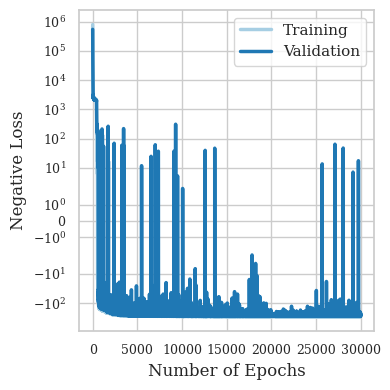

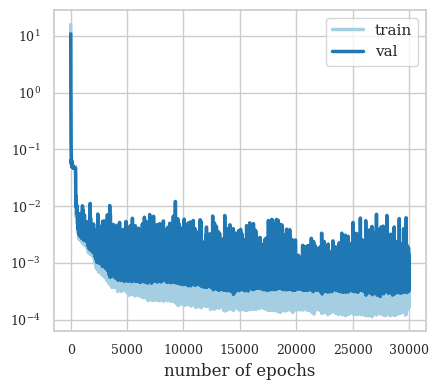

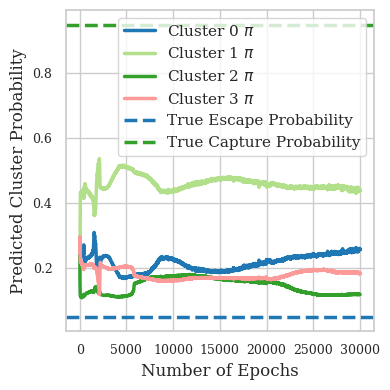

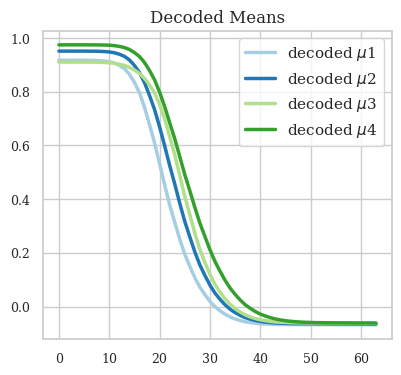

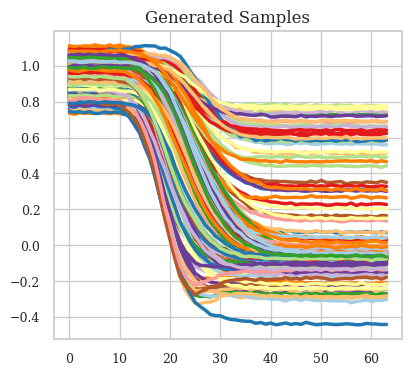

In [30]:
epoch = 29999
epoch = 30_000
params = {}
encoder = Encoder(data_dim=data_dim, latent_dim=latent_dim, hidden_dims=[hd1, hd2, hd3]).to("cuda")
decoder = Decoder(data_dim=data_dim, latent_dim=latent_dim, hidden_dims=[hd3, hd2, hd1]).to("cuda")
encoder_list = [encoder]
decoder_list = [decoder]

device = next(encoder.parameters()).device
# Load in training history metrics
pi_history = torch.load(os.path.join(dirname, 'pi_history'+ postfix + '.pt'))
train_loss = torch.load(os.path.join(dirname, 'train_loss'+ postfix + '.pt'))
val_loss = torch.load(os.path.join(dirname, 'val_loss'+ postfix + '.pt'))
train_elbo_terms = torch.load(os.path.join(dirname, 'train_elbo_terms'+ postfix + '.pt'))
val_elbo_terms = torch.load(os.path.join(dirname, 'val_elbo_terms'+ postfix + '.pt'))
train_mse_history = torch.load(os.path.join(dirname, 'train_mse_history'+ postfix + '.pt'))
val_mse_history = torch.load(os.path.join(dirname, 'val_mse_history'+ postfix + '.pt'))


text_labels = [f'Cluster {i}' for i in range((n_clusters))]
label_colors = [f'C{i+1}' for i in range((n_clusters))]
data_colors = label_colors

# Plot training history
# Plot the training and validation loss vs. epoch number
plt.figure(figsize=(4, 4))
const = min(min(train_loss), min(val_loss))
print(const)
# const = min(10, const)
train_loss_adjusted = train_loss
val_loss_adjusted = val_loss
plt.plot(train_loss_adjusted.cpu(), label='Training')
plt.plot(val_loss_adjusted.cpu(), label='Validation')
plt.xlabel("Number of Epochs")
plt.ylabel("Negative Loss")
# plt.title("Negative Loss")
plt.yscale('symlog')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dirname, 'elbo_'+ str(epoch)+postfix+'.png'), dpi=dpi)
# plt.close()


 # Plot each term of the training loss and validation loss
plt.figure(figsize=(4.5, 4))
labels = ["Reconstruction", "GMM Reg", "Prob Reg", "Encoder Var"]
for ii in range(4):
  # print(train_elbo_terms.cpu()[ii, :epoch])
  # print(len(train_elbo_terms.cpu()[ii, :epoch]))
  train_loss_adjusted = train_elbo_terms[:, ii]
  val_loss_adjusted = val_elbo_terms[:, ii]
  plt.plot(train_loss_adjusted.cpu()[:], label=f"{labels[ii]}: Train")
  plt.plot(val_loss_adjusted.cpu()[:], label=f"{labels[ii]}: Val", linestyle='--')
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.title("Negative Loss Terms")
plt.yscale('symlog')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dirname, 'elbo_terms_'+ str(epoch)+postfix+'.png'), dpi=dpi)
plt.close()


 # Plot the sum of each term of the training loss and validation loss
plt.figure(figsize=(4.5, 4))
  # print(train_elbo_terms.cpu()[ii, :epoch])
  # print(len(train_elbo_terms.cpu()[ii, :epoch]))
train_loss_adjusted = train_elbo_terms.sum(axis=1)
val_loss_adjusted = val_elbo_terms.sum(axis=1)
plt.plot(train_loss_adjusted.cpu()[:], label=f"Train")
plt.plot(val_loss_adjusted.cpu()[:], label=f"Val", linestyle='--')
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.title("Sum of ELBO Terms")
plt.yscale('symlog')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dirname, 'elbo_terms_sum_'+ str(epoch)+postfix+'.png'), dpi=dpi)
plt.close()

# Plot the training and validation mse vs. epoch number
plt.figure(figsize=(4.5, 4))
plt.semilogy(train_mse_history.cpu().detach().numpy(), label='train')
plt.semilogy(val_mse_history.cpu().detach().numpy(), label='val')
plt.xlabel("number of epochs")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dirname, 'reconst_mse_'+ str(epoch)+postfix+'.png'), dpi=dpi)
# plt.close()

# Plot the history of pi
plt.figure(figsize=(4, 4))
for i in range(K):
    plt.plot(pi_history[:, i].cpu().detach().numpy(), label=text_labels[i]+r' $\pi$', color=label_colors[i])
plt.xlabel("Number of Epochs")
plt.ylabel("Predicted Cluster Probability")
plt.axhline(y=0.05, color='C1', linestyle='--', label='True Escape Probability')
plt.axhline(y=0.95, color='C3', linestyle='--', label='True Capture Probability')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(dirname, 'pi_'+ str(epoch)+postfix+'.png'), dpi=dpi)
# plt.close()

# Load best model saved
params['pi_c'] = torch.load(os.path.join(dirname, 'gmm_params_pi'+ postfix + '.pt'))
params['mu_c'] = torch.load(os.path.join(dirname, 'gmm_params_mu'+ postfix + '.pt'))
params['logsigmasq_c'] = torch.load(os.path.join(dirname, 'gmm_params_logsigmasq'+ postfix + '.pt'))
encoder.load_state_dict(torch.load(os.path.join(dirname, 'encoder'+ postfix + '.pt')))
decoder.load_state_dict(torch.load(os.path.join(dirname, 'decoder'+ postfix + '.pt')))

encoder.eval()
decoder.eval()


# run one last EM step and plot training data in latent space
for encoder in encoder_list:
    encoder.eval()

with torch.no_grad():
    means = []
    samples = []
    labels = []
    params['hist_weights'] = torch.zeros((K, 1))
    params['hist_mu_c'] = torch.zeros((K, latent_dim))
    params['hist_logsigmasq_c'] = torch.zeros((K, latent_dim))
    for batch in train_loader:
        batch_x, batch_label = batch
        x_list = [batch_x]
        mu, logsigmasq = encoder_step(x_list, encoder_list, decoder_list)
        sigma = torch.exp(0.5 * logsigmasq)
        eps = Normal(0, 1).sample(mu.shape)
        z = mu + eps * sigma
        with torch.no_grad():
            gamma_c, mu_c, logsigmasq_c = em_step(z, mu, logsigmasq, params, update_by_batch=True)
        params['mu_c'] = mu_c
        params['logsigmasq_c'] = logsigmasq_c

        means.append(mu)
        samples.append(z)
        labels.append(batch_label)

means = torch.vstack(means).cpu()
samples = torch.vstack(samples).cpu()
labels = torch.hstack(labels).cpu()


savepath = os.path.join(dirname, "BEST_latent_samples"+postfix)
plot_latent_space_with_clusters(samples, labels, K, mu_c.cpu(), logsigmasq_c.cpu(), savepath, text_labels, label_colors, data_colors, dpi=dpi)

savepath = os.path.join(dirname, "BEST_latent_means"+postfix)
plot_latent_space_with_clusters(means, labels, K, mu_c.cpu(), logsigmasq_c.cpu(), savepath, text_labels, label_colors, data_colors, dpi=dpi)

# plot test data in latent space
with torch.no_grad():
    test_means = []
    test_labels = []
    for batch in test_loader:
        batch_x, batch_label = batch
        x_list = [batch_x]
        mean, _ = encoder_step(x_list, encoder_list, decoder_list)
        test_means.append(mean)
        test_labels.append(batch_label)

test_means = torch.vstack(test_means).cpu()
test_labels = torch.hstack(test_labels).cpu()


savepath = os.path.join(dirname, "BEST_test_latent_samples"+postfix)
plot_latent_space_with_clusters(test_means, test_labels, K, mu_c.cpu(), logsigmasq_c.cpu(), savepath, text_labels, label_colors, data_colors, dpi=dpi)

# plot decoding results from cluster means # todo: expand this function for multi-modal data
fig, ax = plt.subplots(figsize=(4.5, 4))
for i in range(K):
    # with torch.no_grad:
    x_mean = decoder.forward(params['mu_c'][i])[0]
    ax.plot(x_mean.cpu().detach().numpy(), label="decoded $\mu$"+str(i+1))
ax.legend()
plt.title("Decoded Means")
fig.savefig(os.path.join(dirname, "BEST_decoded_means"+postfix+'.png'), dpi=dpi)
# plt.close()

# plot samples from generative model
n_gen = n_train
cluster_probs = params['pi_c'].cpu().detach().numpy()
fig, ax = plt.subplots(figsize=(4.5, 4))
for j in range(n_gen):
    c = np.random.choice(K, p=cluster_probs)
    # print(c)
    mu_c = params['mu_c'][c].cpu().clone().detach()
    sigma_c = torch.exp(0.5 * params['logsigmasq_c'][c]).cpu().clone().detach()
    z = Normal(0, 1).sample(mu_c.shape).cpu().clone().detach() * sigma_c + mu_c
    # print(z)
    mu_x = decoder.forward(z.cuda())[0].cpu().clone().detach()
    sigma_x = torch.exp(0.5 * decoder.forward(z.cuda())[1])
    sample_x = Normal(0, 1).sample(mu_x.shape).cpu().clone().detach() * sigma_x.cpu().clone().detach() + mu_x
    ax.plot(sample_x.cpu().detach().numpy())
plt.title("Generated Samples")
fig.savefig(os.path.join(dirname, "BEST_generate_samples"+postfix+'.png'), dpi=dpi)
# plt.close()

np.savez(dirname + postfix, train_loss=train_loss.cpu().detach().numpy(), val_loss=val_loss.cpu().detach().numpy(),
      train_mse=train_mse_history.cpu().detach().numpy(), val_mse=val_mse_history.cpu().detach().numpy(),
      pi_history=pi_history.cpu().detach().numpy(),
      cluster_probs=params['pi_c'].cpu().detach().numpy(),
      cluster_means=params['mu_c'].cpu().detach().numpy(),
      cluster_vars=torch.exp(params['logsigmasq_c']).cpu().detach().numpy())


print("Training data size", n_train)
print("Fraction of downward curves:", (torch.sum(labels == 0) / n_train).item())
print("Cluster 1 probability:", cluster_probs.min().item())
print("Error:", str(abs(cluster_probs.min().item() - 0.2573)))